## 5. Toplogical analyisis on the important microbes


In `MEGMA`, the micribes are embedded into 2D based on their correlation distance using the UMAP-mediated manifold learning approach. In this section, let's explore the toplogical relationship between the microbes. We can first fetch the optimized topological weighted graph in 2D based on their correlations, then we can show how the linear assignment algrithm to assign the microbes into the reglar grid to form the feature maps.

[5.1 Plotting the the embedded and arranged microbes](#5.1-Plotting-the-the-embedded-and-arranged-microbes)

[5.2 Plotting the linear assignment of the embedded microbes](#5.2-Plotting-the-linear-assignment-of-the-embedded-microbes)

[5.3 Fetching the optimized toplogical graph and clustering](#5.3-Fetching-the-optimized-toplogical-graph-and-clustering)

[5.4 Exploring the toplogical relationship of the important microbes](#5.4-Exploring-the-toplogical-relationship-of-the-important-microbes)

### 5.1 Plotting the the embedded and arranged microbes

We can plot the embedded microbes using the `plot_scatter` method, the 2D-arrangments can be visulized by the `plot_grid` method.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist, squareform
from scipy.stats import entropy, truncnorm
import networkx as nx
import markov_clustering as mc

from aggmap import loadmap

sns.set(style='white',  font='sans-serif', font_scale=1.5)

In [2]:
megma_all = loadmap('./megma/megma.all')
megma_all.df_scatter.y = -megma_all.df_scatter.y
megma_all.df_embedding.y = -megma_all.df_embedding.y

In [3]:
megma_all.plot_scatter(htmlpath='./images', radius=5, enabled_data_labels=False)

2022-08-24 14:55:28,717 - INFO - [bidd-aggmap] - generate file: ./images/feature points_849_correlation_umap_scatter
2022-08-24 14:55:28,725 - INFO - [bidd-aggmap] - save html file to ./images/feature points_849_correlation_umap_scatter


In [4]:
megma_all.plot_grid(htmlpath='./images')

2022-08-24 14:55:28,734 - INFO - [bidd-aggmap] - generate file: ./images/feature points_849_correlation_umap_mp
2022-08-24 14:55:28,784 - INFO - [bidd-aggmap] - save html file to ./images/feature points_849_correlation_umap_mp


Since megma rearranges the microbes into 2D based on their abundance correlations, we can show the mean abundance of these microbes in the embedded 2D space and 2D-grid. We can see the local smoothing on the mean abundance of the microbes. 

Text(599.4818181818181, 0.5, 'Y')

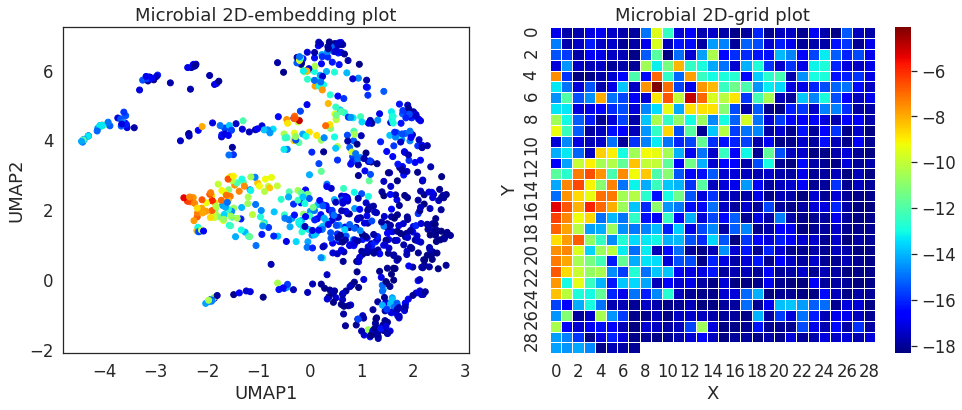

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (16, 6))

p = megma_all.df_scatter.set_index('IDs').join(megma_all.info_scale['mean'])
ax1.scatter(p.x, p.y, c = p['mean'], cmap = 'jet')

df = pd.DataFrame(index=megma_all.feature_names_reshape)
tm = df.join(megma_all.info_scale['mean']).values.reshape(*megma_all.fmap_shape)
sns.heatmap(tm, cmap = 'jet', ax = ax2, linewidths = 0.5)

ax1.set_title('Microbial 2D-embedding plot')
ax1.set_xlabel('UMAP1')
ax1.set_ylabel('UMAP2')

ax2.set_title('Microbial 2D-grid plot')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')


### 5.2 Plotting the linear assignment of the embedded microbes

Let us show how embedded microbes can be assigned to a 2D grid. After assignment, each grid point is a pixel, i.e., the microbial abundance feature point.


In [6]:
def plot_assignment(df_embedding, figsize = (10, 9)):
    
    df_sub2 = df_embedding.copy()
    grid = megma_all.df_grid_reshape.set_index('v')[['x', 'y']]
    grid.columns=['g_x', 'g_y']
    dfs = df_sub2.join(grid)

    w = dfs.g_x.max() + 1
    h = dfs.g_y.max() + 1

    my_grid = np.dstack(np.meshgrid(np.linspace(dfs.min().x, dfs.max().x, w), np.linspace(dfs.max().y, dfs.min().y, h))).reshape(-1,2)
    my_grid_index = np.dstack(np.meshgrid(np.linspace(0, w-1, w), np.linspace(0, h-1, h))).reshape(-1,2)

    dfg = pd.DataFrame(my_grid, columns=['t_x', 't_y'], )
    dfi = pd.DataFrame(my_grid_index.astype(int), columns=['g_x', 'g_y'])

    dfn = dfg.join(dfi).set_index(['g_x', 'g_y'])

    dfs = dfs.sort_values(['g_y', 'g_x']).set_index(['g_x','g_y'])
    dfs = dfs.join(dfn)

    fig, ax = plt.subplots(figsize = figsize)

    for i in range(len(dfs)):
        ts = dfs.iloc[i]
        ax.arrow(ts.x, ts.y, ts.t_x-ts.x, ts.t_y-ts.y, 
                 color = ts.colors, head_width = 0.08,  head_length=0.1, overhang = 0.5, lw=1)

    # nx.draw_networkx(g, pos=sub_pos, node_size = 200, labels=labeldict, with_labels = False, edgecolors = 'grey',
    #                  edge_color = 'gray', alpha = 1, width = 0.09, node_color= subgraph_colors)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    fig.tight_layout()
    return fig

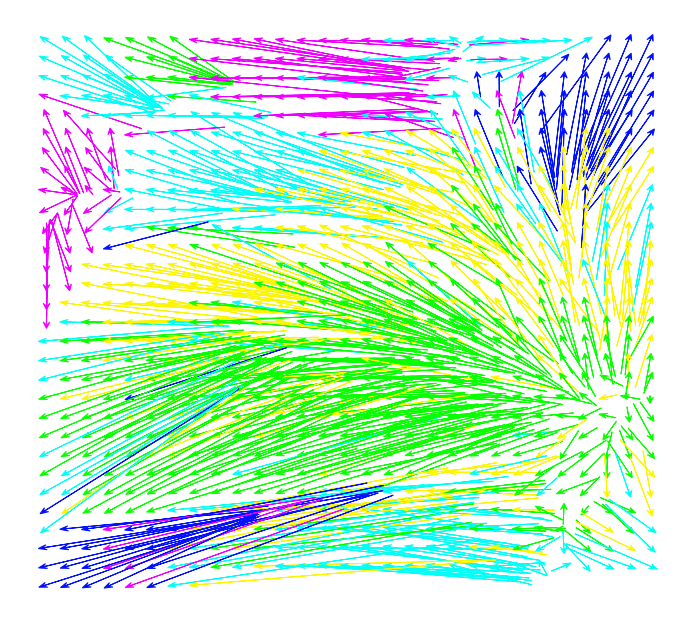

In [7]:
fig = plot_assignment(megma_all.df_embedding)

### 5.3 Fetching the optimized toplogical graph and clustering

Based on the global feature importance (GFI) and the saliency map analysis in previous section, we know that the important microbes in `megma_all` are located in the left upper corner. Therefore, we can obtain the microbes in this area by clustering the topological weighted graph of the 2D-embedding (the area highlighted with red-box). Let's fetch the low-dimensional topological graph first.

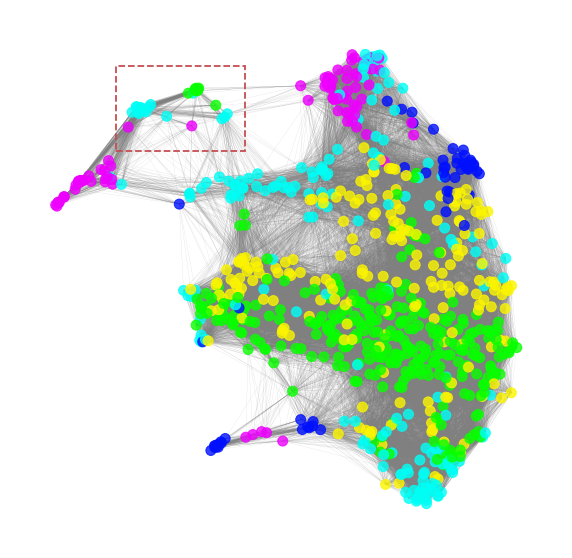

In [8]:
def get_graph_v(embd):
    '''
    Get the low dimensional graph
    '''
    distances = cdist(embd.embedding_, embd.embedding_)
    a = embd._a
    b = embd._b
    ## acorrding to UMAP defined low-D graph 
    graph_v = 1.0 / (1.0 + a * distances ** (2 * b))       
    return graph_v


gv = get_graph_v(megma_all.embedded)
#np.fill_diagonal(gv,0)
A = gv*(gv > 0.2)
np.fill_diagonal(A, 0.)
G = nx.from_numpy_matrix(np.matrix(A))

# layout = nx.spring_layout(G, iterations = 900)

dfs = megma_all.df_embedding

positions = dfs.reset_index()[['x', 'y']]
pos = {}
for i in range(len(positions)):
    pos.update({i:positions.iloc[i].values})
    
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw(G, pos=pos, ax = ax, node_size = 100, edge_color = 'gray', #edgecolors = 'grey', 
        alpha = 0.8, width = 0.09, node_color= dfs.colors)
#nx.draw_networkx_edge_labels(G, pos=layout)
rect = patches.Rectangle((-3.5, 5), 2, 1.6, linewidth=1.8, ls = '--', edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

We can then use the [Markov clustering](http://micans.org/mcl/) to cluster the graph into several subgraphs, and pick up the cluster of the important microbes. In this cluster, the important cluster is 7 (i.e., the yellow color cluster)

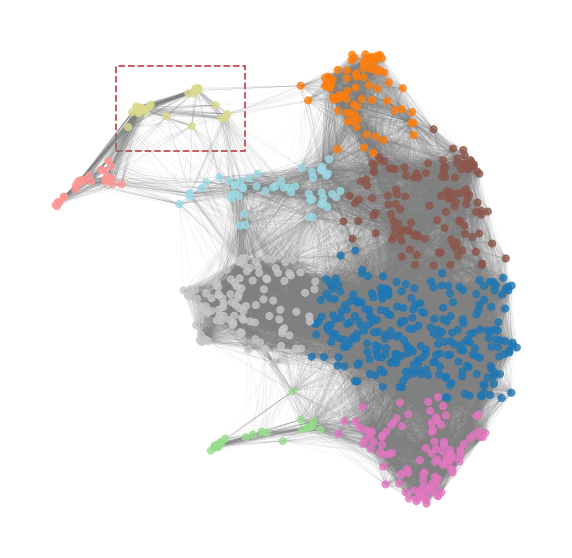

In [9]:
matrix = nx.to_scipy_sparse_matrix(G)
result = mc.run_mcl(matrix)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters
cluster_map = {node: i for i, cluster in enumerate(clusters) for node in cluster}
colors = [cluster_map[i] for i in range(len(G.nodes()))]

fig, ax = plt.subplots(figsize = (10, 10))

rect = patches.Rectangle((-3.5, 5), 2, 1.6, linewidth=1.8, ls = '--', edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

nx.draw(G, pos=pos, ax = ax, node_size = 50, edge_color = 'gray', 
        alpha = 0.8, width = 0.07, node_color= colors, cmap = 'tab20')


### 5.4 Exploring the toplogical relationship of the important microbes

The important cluster will be picked and drawn in the figure below. We can see that the selected important cluster contains 35 important microbes, 11 microbes are in green color (cluster_02 of the hierarchical clustering based on the abundance distance), 22 are in blue color (cluster_03), and 2 are in purple color(cluster_05). We can see that these microbes are highly-correlated in each other on their abundances.

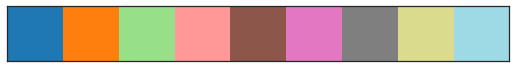

In [10]:
import cmasher as cmr
l = pd.Series(colors).value_counts().sort_index()
colors_ = cmr.take_cmap_colors('tab20', len(l), return_fmt='hex')
sns.palplot(colors_)

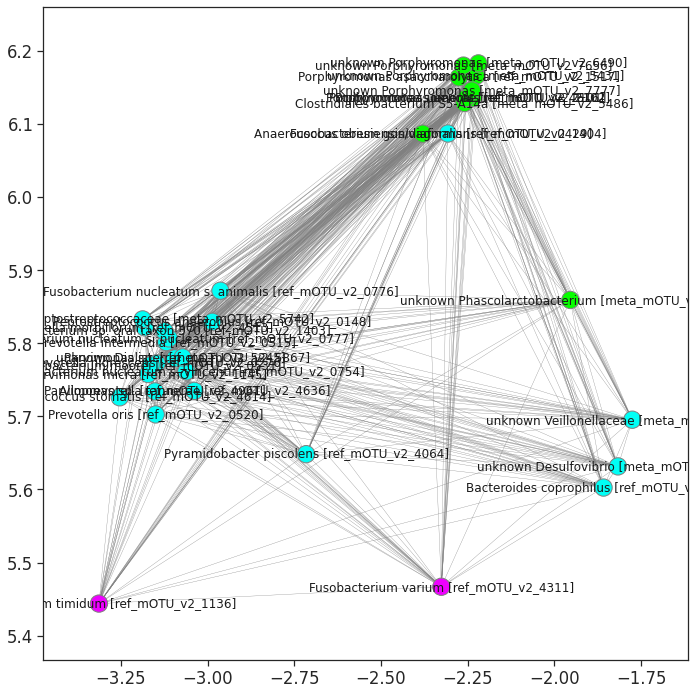

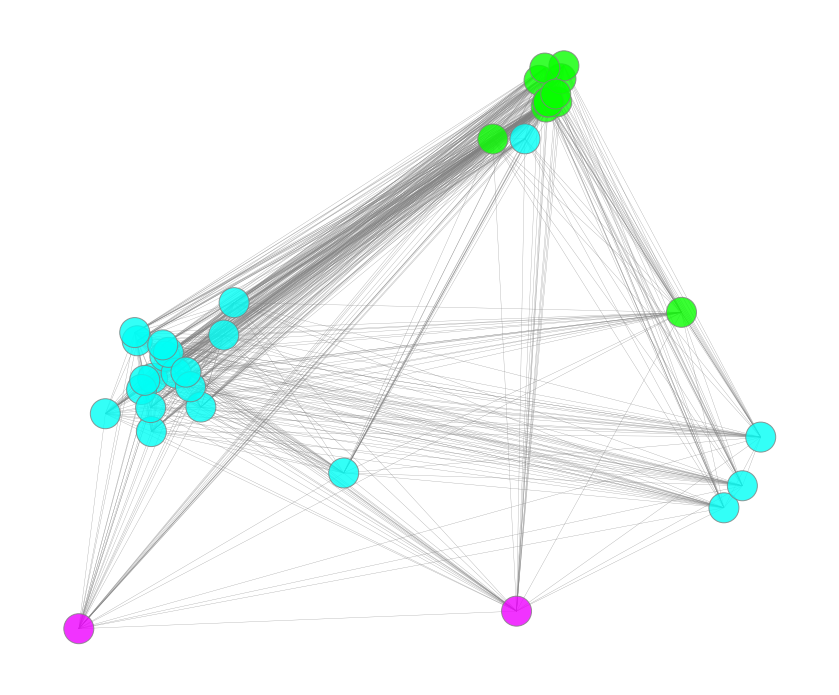

In [11]:
i = 7 ## selected cluster

important_nodes = pd.Series(colors)[pd.Series(colors)==i].index.to_list()
df_sub = dfs[(pd.Series(colors)== i).values]
sub_positions = positions[(pd.Series(colors)==i).values]
sub_pos = {}
for i in range(len(sub_positions)):
    ts = sub_positions.iloc[i]
    sub_pos.update({ts.name:ts.values})
    

g = G.subgraph(important_nodes)
subgraph_colors = df_sub.set_index('idx').loc[list(g.nodes)].colors


#df_sub.index = df_sub.index.map(lambda x:x.split(' [')[0])
# df_sub = df_sub[~df_sub.index.duplicated(keep='first')]
labeldict = df_sub.reset_index().set_index('idx')['index'].to_dict()


fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, pos=sub_pos, node_size = 300, labels=labeldict, with_labels = True, edgecolors = 'grey',
                 edge_color = 'gray', alpha = 1, width = 0.3, node_color= subgraph_colors)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
fig.tight_layout()
fig.savefig('./images/label_35_graph.pdf', dpi=400) 

fig, ax = plt.subplots(figsize = (12, 10))
nx.draw_networkx(g, pos=sub_pos, node_size = 900, labels=labeldict, with_labels = False, edgecolors = 'grey',
                 edge_color = 'gray', alpha = 0.8, width = 0.3, node_color= subgraph_colors)

ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.bottom.set_visible(False)
fig.tight_layout()
fig.savefig('./images/unlabel_35_graph.pdf', dpi=400) 

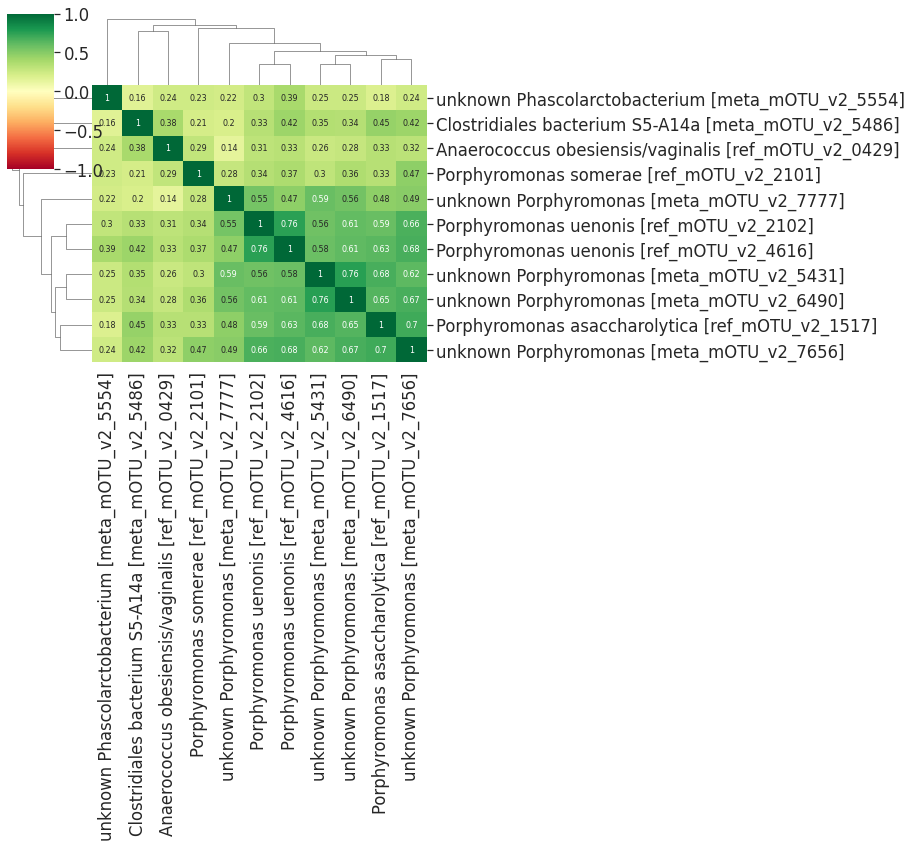

In [12]:
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as hc

dist = pd.DataFrame(squareform(megma_all.info_distance), 
                    columns=megma_all.flist, index = megma_all.flist)

l2 = df_sub[df_sub.Channels == 'cluster_02']
dist_matrix = dist.loc[l2.index][l2.index]
linkage = hc.linkage(squareform(dist_matrix), method='average', optimal_ordering =False)

sns.clustermap(1-dist_matrix,  cmap='RdYlGn', annot=True, 
               row_linkage=linkage, col_linkage=linkage,
               annot_kws={"size": 8}, vmin=-1, vmax=1, figsize=(13,12))

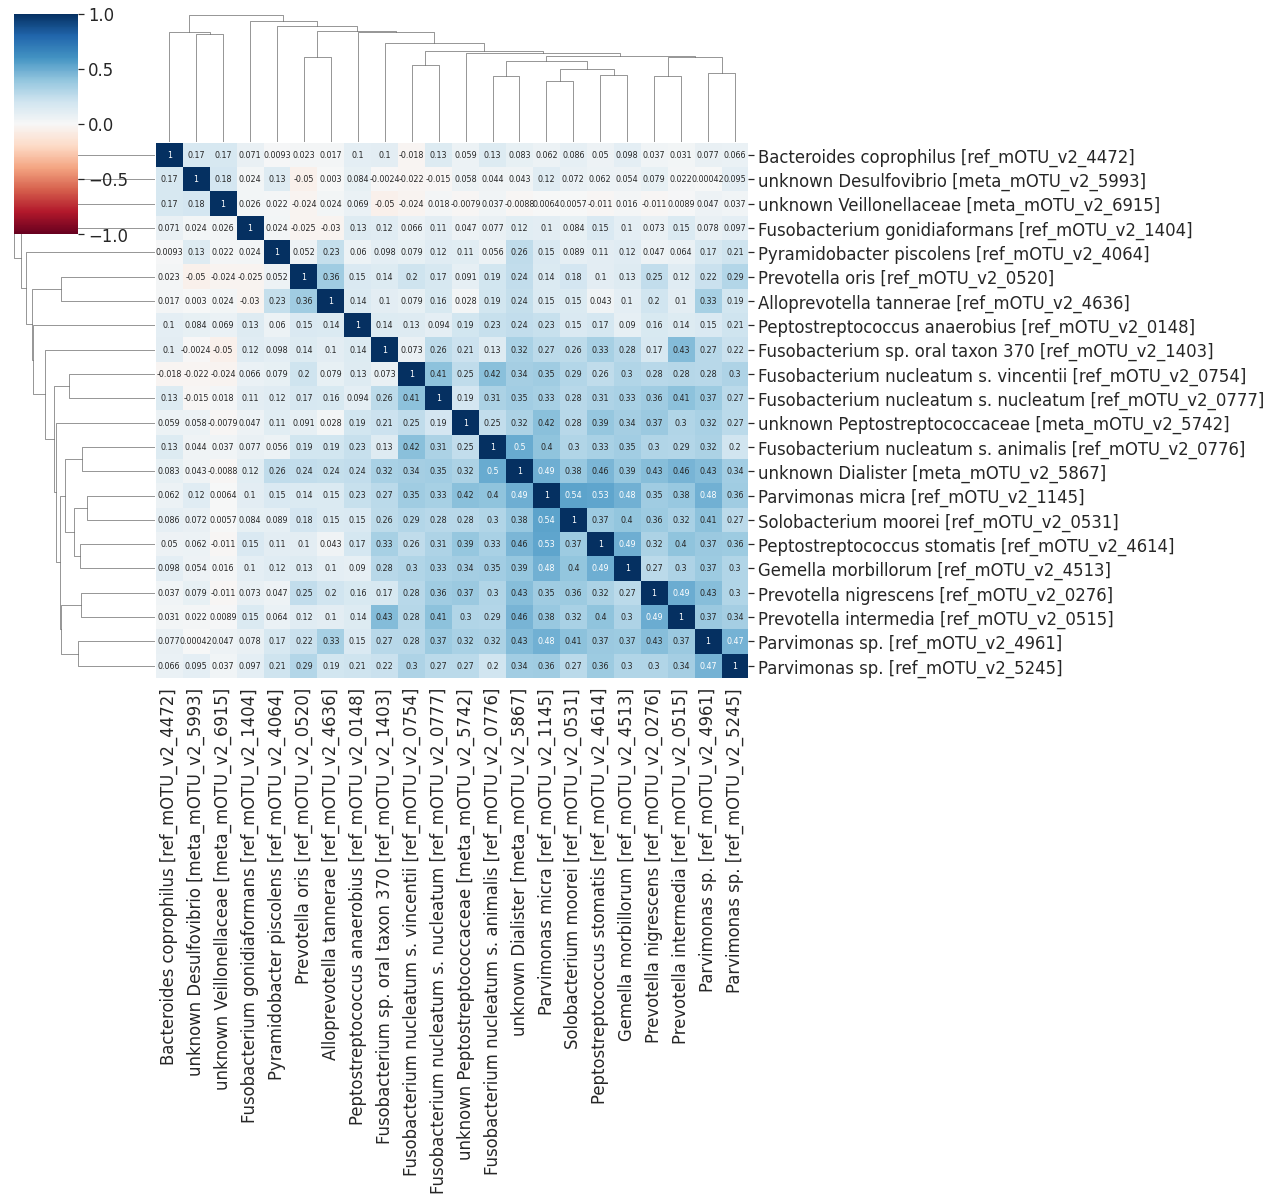

In [13]:
l2 = df_sub[df_sub.Channels == 'cluster_03']
dist_matrix = dist.loc[l2.index][l2.index]
linkage = hc.linkage(squareform(dist_matrix), method='average', optimal_ordering =False)

sns.clustermap(1-dist_matrix,  cmap='RdBu', annot=True, 
               row_linkage=linkage, col_linkage=linkage,
               annot_kws={"size": 8}, vmin=-1, vmax=1, figsize=(18,17))